## 2. Preprocessing

After having a look on the datas, we want to pre-process the features for our algorithms. To do such a thing, we know that data have to be clean and well scale in order to maximize the learning of model :  **garbage in garbage out !**

The different steps we have planned are :
- **Verify the data**: Verify that all the data is correct (no missing and with the good type)
- **Scales features**: use of zcore as usual
- **Treate Outliers**: none normally
- **Dataset splitting**: cross validation and test set
- **Features selection**: see correlation and real impact via filter/wrapper methods and dimensionality reduction

In [ ]:
# Classical libraries
import numpy as np
import matplotlib.pyplot as plt

#Libraries for Pre-processing
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from yellowbrick.features import rank1d, rank2d

#Libraries for ML models
from sklearn.ensemble import RandomForestClassifier as RF

#Our functions
%cd ..
from src.preprocessFnct import bacwardWrapper, runForward, plot_feature_importance

### Datas Pre-processing

Before starting anything, let us check if is not any missing value in our dataset

In [2]:
# load dataset
%store -r dataset
np.any(np.isnan(dataset.values))

False

There is no missing value in our dataset, we do not have to do any operation.

**Remark:** Previously we have done a log transformation for the *Income* and *Wealth* features in the dataset.

Then, we normalise our data with the z-score technique.

In [3]:
#We convert it into a numpay array
data = dataset[["Age","Gender", "FamilyMembers", "FinancialEducation", "RiskPropensity", "logIncome", "logWealth"]].values

#We apply the z-score
X =  zscore(data)

After we extract the targets from our dataset.

In [4]:
# we store the target
t_inc = dataset['IncomeInvestment'].values == 1
t_acc = dataset['AccumulationInvestment'].values == 1

And to finish, we split randomly our dataset into two subsets: The training set (with 80% of the datas) and the Test set (with 20% of the datas).

In [5]:
#Train = 80% % ; Test = 20 %
X_train, X_test, Inc_train, Inc_test, Acc_train, Acc_test = train_test_split(X, t_inc, t_acc, test_size=0.2, shuffle=True, random_state=0)

We have clean our dataset, let us pass to the feature selection.

### Features Selection

**Idea :** We are going to first use filtration methods on our feature. This allow us to rank them subject to different metrics. This is usefull since it have a low cost but can neglect correlation over data or feature so this is just a first step. 

In addition, we will use wrapper methods. Backward to confirm or affirm result get from filtration. Forward to better rank our features.

We are also going to see some feature importance (a bit of interpretability) to have a first real explanation on how can be modeled our data. 

To do so, we will use simple models that allow interpretability and and a reasonable computational cost. For that, we have chosen to deal with a Decision Tree.

To conclude, we of course need to process a PCA as it is done to reduce the dimensionality of our problem. Let us see all of these methods!

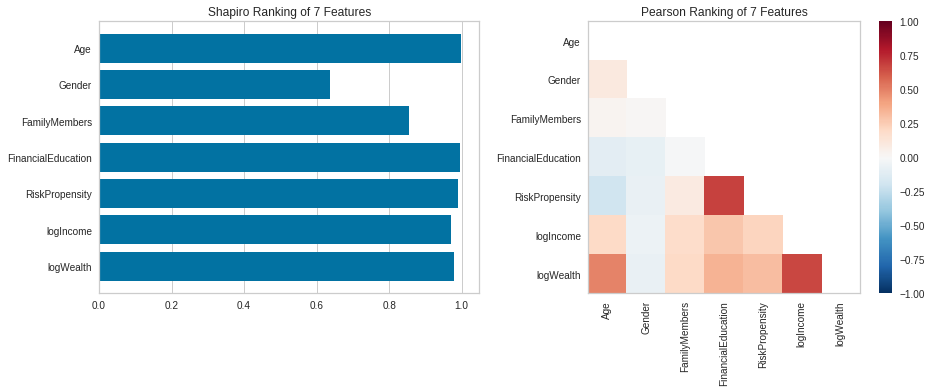

In [6]:
# First : filtration method
_, axes = plt.subplots(1, 2, figsize=(15,5))
rank1d(dataset.drop(["IncomeInvestment", "AccumulationInvestment" ], axis=1), ax=axes[0], show=False)
rank2d(dataset.drop(["IncomeInvestment", "AccumulationInvestment" ], axis=1), ax=axes[1], show=False)
plt.show()

Shapiro ranking can be seen as a ranking on how is the variability, stationnarirty or things like this of the data regarding the different features. It can be biased since there is no model but it give some information. Correlation rank is obvious.

We can see that as expected, *FamilyMembers* and *Gender* have a lowest importance than the other. Gender is clearly not correlated with others features and confirm the well distributed fact over the others features, making it useless in our point of view.

We also see again the correlation between *RiskPropensity* and *FinancialEducation*, and *logIncome* and *logWealth*, that may be very important features to explain the model.

Another point that confirm our idea about the fact that *Age* is more relevant than *FamilyMembers* is that we can see a correlation between age and wealth (obvious when we think so). Thus we think *Age* will give more information in different models.

The correlation between *Income* and *Wealth* can also be obvisous since more income lead to bigger wealth. 

#### Backward approach

Let's now train a simple model to do a Backward approach, to validate this observation.

We base it on the accuracy since it is simple to have it and an easy interpretable score, but we will see later that others metrics are more relevant for our problem

In [7]:
# Backward wrapper method for AccumulationInvstment target
bacwardWrapper(X_train, X_test, Acc_train, Acc_test, "AccumulationInvstment")

full accuracy for AccumulationInvstment :  0.728
without  Age and with the rest 0.697
without  Gender and with the rest 0.734
without  FamilyMembers and with the rest 0.729
without  FinancialEducation and with the rest 0.738
without  RiskPropensity and with the rest 0.732
without  logIncome and with the rest 0.607
without  logWealth and with the rest 0.606


In [8]:
# Backward wrapper method for IncomeInvstment target
bacwardWrapper(X_train, X_test, Inc_train, Inc_test, "IncomeInvstment")

full accuracy for IncomeInvstment :  0.719
without  Age and with the rest 0.67
without  Gender and with the rest 0.728
without  FamilyMembers and with the rest 0.721
without  FinancialEducation and with the rest 0.71
without  RiskPropensity and with the rest 0.707
without  logIncome and with the rest 0.667
without  logWealth and with the rest 0.605


Here, we train a Decision Tree model for classification with all the features and then without one of them, for the prediction of our two target.

For both, models without *Age*, *logIncome* and *logWealth* decrease significativly the accuaracy. We can understand so that is important features for the prediction.

For the target **AccumulationInvestment**, removing the feature *FinancialEducation*, *Gender*, *FamilyMembers* or *RiskPropensity* decrease non significativly the accuracy (or can increase it in some tests cases depends on the train dataset and the model choosen).

For the target **IncomeInvestment**, removing the feature *Gender* or *FamilyMembers* modify once again the accuracy non-significativly.

#### Forward approach

Let us see what happend with a forward approach. The idea is to start from scratch and add to the model the feature wich increase the most the accuracy at each step until all the features are in the models.

To test our previous idea, we do this operation with 4 sets of features: One with all, One without *Gender*, one without *FamilyMembers* and then of without this 2 features.

We will see if what we saw is confirmed by this method.

In [9]:
#Forward Stepwise Selection for IncomeInvestment
#Rappel: {0:"Age", 1:"Gender", 2:"FamilyMembers", 3:"FinancialEducation", 4:"RiskPropensity", 5:"logIncome", 6: "logWealth"}
runForward(X_train, X_test, Inc_train, Inc_test, isInc=1)

with all: ([0, 1, 2, 6, 5, 3, 4], [0.71, 0.706, 0.68, 0.643, 0.699, 0.703, 0.694])
without Gender:  ([0, 2, 6, 5, 3, 4], [0.71, 0.694, 0.636, 0.696, 0.695, 0.699])
without FamMem:  ([0, 1, 6, 5, 3, 4], [0.71, 0.706, 0.651, 0.695, 0.698, 0.695])
without both:  ([0, 6, 5, 3, 4], [0.71, 0.655, 0.691, 0.696, 0.696])


Let start by the first target. We can see that for the **IncomeInvstment** model, the feature *Age* (number 0) is the most important. For a coherent model, we choose to do not have only one feature in the model even if the accuracy is the biggest.

**Results:** For this test, we can see that the biggest accuracy, according to our choice, is the model with the third set (without *FamilyMembers*) when we do not add the feature *FinancialEducation*.

In addition, we can find the same features importance in our models (*Age*, *logWealth*, *logIncome*, *RiskPropensity* and *FinancialEducation*). The two features *Gender* and *FamilyMembers* do not affect the models as expected. We can see some similarities with all these models: Whatever the set which used, each model seem converge to the same result. 

We also can remark that the features *RiskPropensity* and *FinancialEducation* improve models accuracy but only if the other is not in the model! It can be explain by their high correlation. We can try to apply a ratio transformation to see if the models are affected by this correlation. 

To conclude, we can say that this technique confirm our doubts on the features *Gender* and *FamilyMembers* which are not usefull for us. In addition, we have to correct the effect of the correlation between *RiskPropensity* and *FinancialEducation* to improve our feature space.

In [10]:
#Forward Stepwise Selection for AccumulationInvestment
#Rappel: {0:"Age", 1:"Gender", 2:"FamilyMembers", 3:"FinancialEducation", 4:"RiskPropensity", 5:"logIncome", 6: "logWealth"}
runForward(X_train, X_test, Acc_train, Acc_test, isInc=0)

with all: ([5, 6, 0, 3, 1, 2, 4], [0.551, 0.708, 0.728, 0.739, 0.747, 0.746, 0.719])
without Gender:  ([5, 6, 0, 3, 2, 4], [0.551, 0.704, 0.739, 0.749, 0.752, 0.724])
without FamMem:  ([5, 6, 0, 4, 1, 3], [0.551, 0.696, 0.737, 0.743, 0.737, 0.732])
without both:  ([5, 6, 0, 3, 4], [0.551, 0.699, 0.733, 0.745, 0.739])


For the target **AccumulationInvestment**, the most relevant feature is *logIncome*. Once again it is coherent with what we saw before.

Here again, we can clearly see that:
- the features *logWealth* and *Age* are also important for our model
- the features *Gender* and *FamilyMembers* are not usefull
- the correlation between *RiskPropensity* and *FinancialEducation* is negative for the models

With this elements, we can make the same conclusion than before. We can remove the features *Gender* and *FamilyMembers* from our feature space and create a new feature which capture the relevant information from the features *RiskPropensity* and *FinancialEducation*.

#### Features correction

Correlation between two features can add repetitive informations. A ratio transformation can catch all the information and remove the repetitive one. Here, we assume to transform only the less important correlated features *FinancialEducation* and *RiskPropensity*.

So we will try the transformation and see if it success to catch the useful informations or not and then make a choice.

In [11]:
#We create our new dataset with the ratio FinancialEducation/RiskPropensity
TT_train = np.c_[X_train[:,[0,1,2]], (X_train[:,3]/X_train[:,4]), X_train[:,[5,6]]]
TT_test = np.c_[X_test[:,[0,1,2]], (X_test[:,3]/X_test[:,4]), X_test[:,[5,6]]]

In [12]:
#Forward Stepwise Selection for IncomeInvestment
#Rappel: {0:"Age", 1:"Gender", 2:"FamilyMembers", 3:"newFeat", 4:"logIncome", 5: "logWealth"}
runForward(TT_train, TT_test, Inc_train, Inc_test, isInc=1, isTest=1)

with all: ([0, 1, 2, 5, 4, 3], [0.71, 0.706, 0.68, 0.638, 0.698, 0.709])
without Gender:  ([0, 2, 5, 4, 3], [0.71, 0.694, 0.637, 0.694, 0.709])
without FamMem:  ([0, 1, 5, 4, 3], [0.71, 0.706, 0.651, 0.701, 0.707])
without both:  ([0, 5, 4, 3], [0.71, 0.65, 0.692, 0.697])


Here the result are very close to the models with the two correlated features. We can see that our new feature always has a positive impact on our test. We can say that the ratio is a concluant experience for modelling the *IncomeInvestment* target.

Now, we have to test our hypothesis on the other target.

In [13]:
#Forward Stepwise Selection for AccumulationInvestment
#Rappel: {0:"Age", 1:"Gender", 2:"FamilyMembers", 3:"newFeat", 4:"logIncome", 5: "logWealth"}
runForward(TT_train, TT_test, Acc_train, Acc_test, isInc=0, isTest=1)

with all: ([4, 5, 0, 3, 2, 1], [0.551, 0.702, 0.73, 0.734, 0.746, 0.725])
without Gender:  ([4, 5, 0, 2, 3], [0.551, 0.698, 0.726, 0.732, 0.736])
without FamMem:  ([4, 5, 0, 1, 3], [0.551, 0.702, 0.73, 0.732, 0.725])
without both:  ([4, 5, 0, 3], [0.551, 0.7, 0.732, 0.738])


Here, once again, we have the same result. The new feature does not change our result.

We succesed to catch the relevant informations of our features *FinancialEducation* and *RiskPropensity*, by doing the ratio, and transfert it on a new feature that we can call "*RatioFeature*".

In [14]:
X_train_old, X_test_old = X_train, X_test

#New dataset
X_train = np.c_[X_train[:,[0,1,2]], (X_train[:,3]/X_train[:,4]), X_train[:,[5,6]]]
X_test = np.c_[X_test[:,[0,1,2]], (X_test[:,3]/X_test[:,4]), X_test[:,[5,6]]]

With simple model, we can thus confirm our idea.
We have to be aware that this is maybe biased since models are simple and we don't optimize them.

Let us see thus with a litle bit more complex model, to reduce the bias : a random forest.
We train it without optimize it but it still relevant for us. We want to compute feature importance that part for interpretability in order to optimize in future model the use of our features.

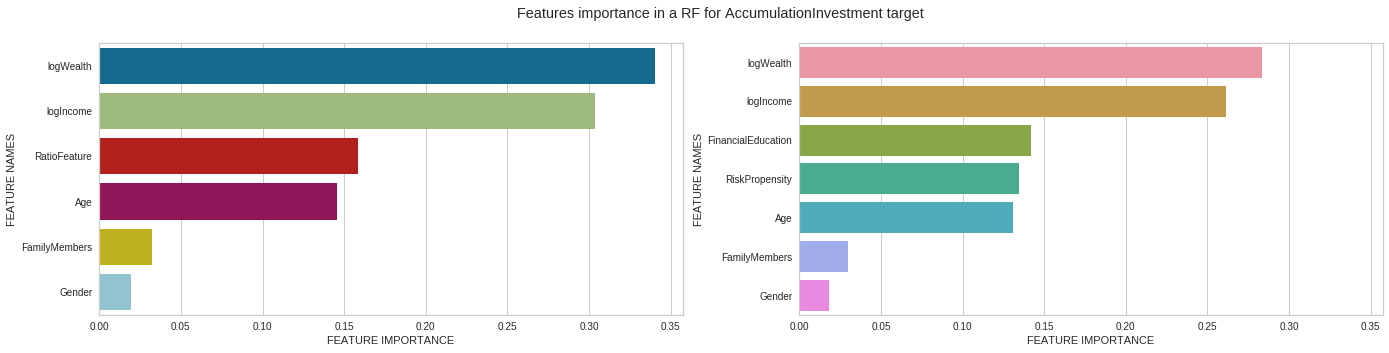

In [15]:
# order of our features
c = ["Age", "Gender", "FamilyMembers", "RatioFeature", "logIncome", "logWealth"]
cOld = ["Age", "Gender", "FamilyMembers", "FinancialEducation", "RiskPropensity", "logIncome", "logWealth"]

#random forest classifier
AccumulationRF, AccumulationRFOld = RF(), RF()
AccumulationRF.fit(X_train, Acc_train)
AccumulationRFOld.fit(X_train_old, Acc_train)
plot_feature_importance(AccumulationRF.feature_importances_, AccumulationRFOld.feature_importances_,
                        c,cOld, 'Features importance in a RF for AccumulationInvestment target')

Here the graph on the left shows the features importance in a randmon forest classifier with the *RatioFeature* where the graph on the rigth shows it with the original dataset.

We can see that the *RatioFeature* has an higher importance than *FinancialEducation* or *RiskPropensity* feature. In addition, the importance in our model of the features *Age*, *logIncome* and *logWealth* also increase where this one of *FamilyMembers* and *Gender* stay the same.

For the target **AccumulationInvestment**, the feature importance is coherent and validate what we have done.

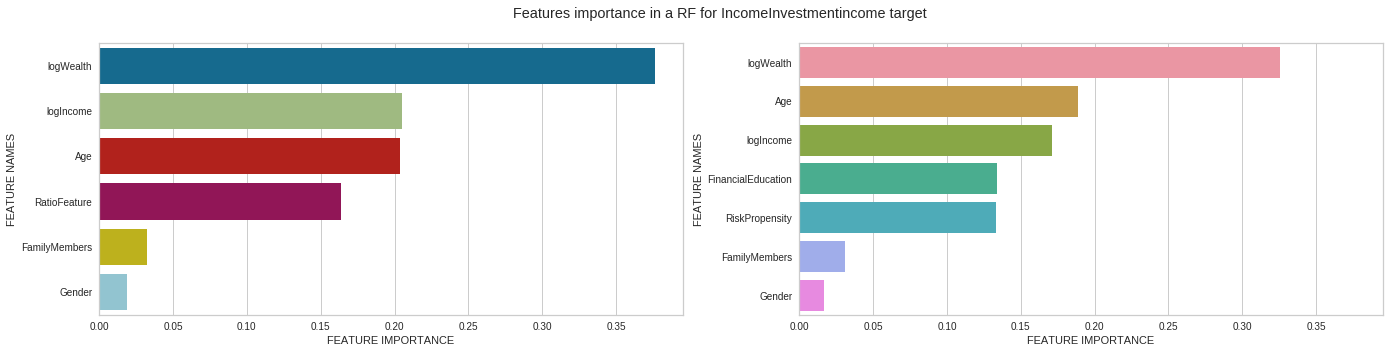

In [16]:
IncomeRF, IncomeRFOld = RF(), RF()
IncomeRF.fit(X_train, Inc_train)
IncomeRFOld.fit(X_train_old, Inc_train)
plot_feature_importance(IncomeRF.feature_importances_, IncomeRFOld.feature_importances_,
                        c, cOld, 'Features importance in a RF for IncomeInvestmentincome target')

Here, once again, the graph on the left shows the features importance in a randmon forest classifier with the *RatioFeature* where the graph on the rigth shows it with the original dataset for the **IncomeInvestmentincome** target.

We can have the same analysis for these graphs. The *RatioFeature* increase the feature importance ratio of the two features. In addtition, all the ratio increase except these of *FamilyMembers* and *Gender*. 

We can say that for the target **IncomeInvestmentincome**, once again, the feature importance is coherent with our previous results.

As we can see, FamilyMembers and Gender doesn't seems to play a big role in our model. This is what we was expected to have and with the different methods we have used, we are quite certain of our result. Others features were important for us and in this last technique it is proves to be just. All seems to have a importance non-negligeable. 

To conclude our features selection, after testing, we decide to remove the features *Gender* and *FamilyMembers* and apply the ratio transformation. We reduce our features space from 7-dimensions to 4-dimensions. Our final space contains the features *Age*, *RatioFeature*, *logIncome* and *logWealth*. The gap isn't huge but it is more for business interpretation. We also avoid overfiting by reducing the problem.

## **Summary :**  

We have shown that our knowledge on the subject can be shown explorating the data. But this is not enough to validate some assumptions and to generalize it to all future dataset. 

We have thus shown that with some simple metrics and models we can model these knowledge and with a known bias interpret the output. 

We are thus almost sure that the features FamilyMembers and Gender aren't relevant for our problem and thus we can remove them before doing complex modelisation. 

This can help us to avoid doing overfitting. Also, it reduce the computational cost. And finally we use the principe of parsimony in the financial way : keep as less as feature needed meaning they have importance and business interpretation.

In [ ]:
#Final Feature Selection

X = np.c_[X[:,0], (X[:,3]/X[:,4]), X[:,[5,6]]] # => ["Age", "FinancialEducation/RiskPropensity", "logIncome", "logWealth"]

%store X
%store t_inc
%store t_acc

We are now ready to train complex models and to provide true performance of ML algorithm in order to solve our problem : match people with their needs